# Bandit Problem

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from bandits import Bandit
import random
# Include your imports here, if any are used. 

A bandit is one option (or “arm”) you can choose, where the reward you get is uncertain and must be learned by trying it out.
In multi-armed bandits, you repeatedly pick among several such uncertain options to find which one pays best.

A list of ten bandit objects initialized in the list...

In [2]:
bandits = [Bandit(random.random()*4-2) for _ in range(10)]

To generate reward from that bandit, use the pullLever() command

In [3]:
bandits[0].pullLever()

-0.24519482129421077

## Greedy algorithm Implementation

In [ ]:
def run_greedy(num_iterations = 1000):
    
    num_bandits = len(bandits)
    counts = np.zeros(num_bandits)  # Number of times each bandit was pulled
    values = np.zeros(num_bandits)  # Estimated value of each bandit
    rewards = []
    
    for i in range(num_iterations):
        # Choose bandit with highest estimated value
        bandit_idx = np.argmax(values)
        
        # Pull the lever and get reward
        reward = bandits[bandit_idx].pullLever()
        rewards.append(reward)
        
        # Update counts and estimates
        counts[bandit_idx] += 1
        # Incremental update: new_estimate = old_estimate + (1/n) * (reward - old_estimate)
        values[bandit_idx] += (reward - values[bandit_idx]) / counts[bandit_idx]
    
    return rewards

Plot the cumulative average of rewards as the number of iterations increases. and display that image below.

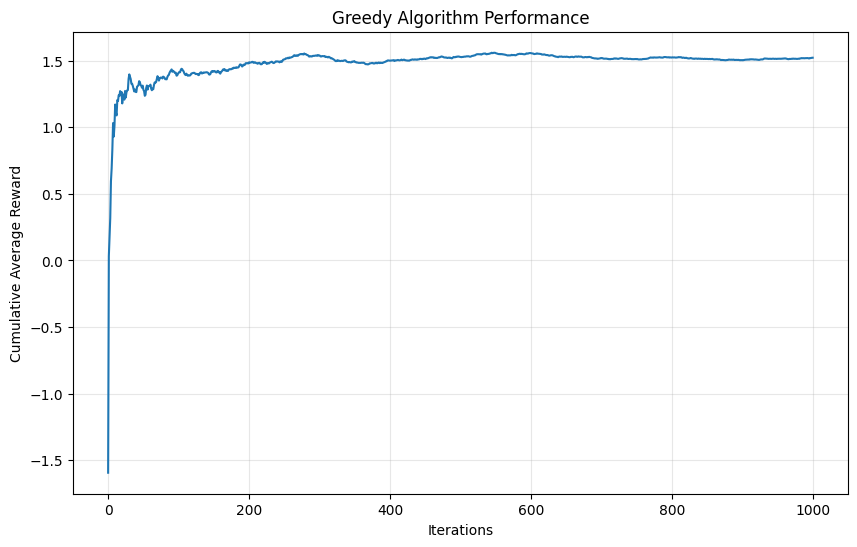

In [5]:
greedy_rewards = run_greedy(1000)
cumulative_avg = np.cumsum(greedy_rewards) / (np.arange(len(greedy_rewards)) + 1)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_avg)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Average Reward')
plt.title('Greedy Algorithm Performance')
plt.grid(True, alpha=0.3)
plt.show()

## $\epsilon$-greedy Algorithm

In [9]:
def run_epsilon_greedy(epsilon, num_iterations=1000):
    
    num_bandits = len(bandits)
    counts = np.zeros(num_bandits)
    values = np.zeros(num_bandits)
    rewards = []
    
    for i in range(num_iterations):
        # Exploration vs Exploitation
        if random.random() < epsilon:
            # Explore: choose random bandit
            bandit_idx = random.randint(0, num_bandits - 1)
        else:
            # Exploit: choose best known bandit
            bandit_idx = np.argmax(values)
        
        # Pull lever and get reward
        reward = bandits[bandit_idx].pullLever()
        rewards.append(reward)
        
        # Update estimates
        counts[bandit_idx] += 1
        values[bandit_idx] += (reward - values[bandit_idx]) / counts[bandit_idx]
    
    return rewards


Plot the cumulative average of rewards as the number of iterations increases but for various values of $\epsilon$.

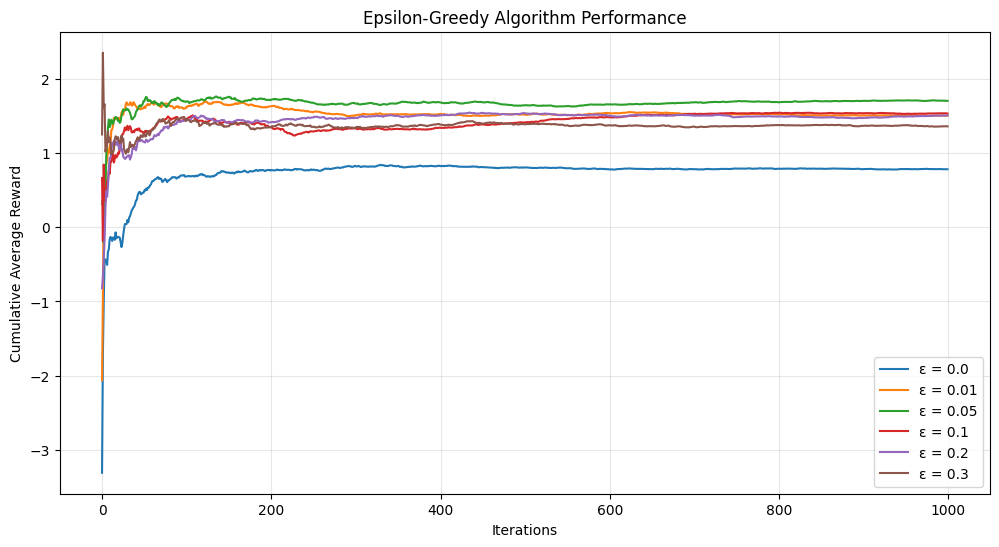

In [10]:
plt.figure(figsize=(12, 6))
epsilon_values = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
for eps in epsilon_values:
    rewards = run_epsilon_greedy(eps, 1000)
    cumulative_avg = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)
    plt.plot(cumulative_avg, label=f'ε = {eps}')

plt.xlabel('Iterations')
plt.ylabel('Cumulative Average Reward')
plt.title('Epsilon-Greedy Algorithm Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Finding the optimal $\epsilon$

Run the $\epsilon$-greedy algorithm for 1000 iterations and find the optimal $\epsilon$ value by plotting the cumulative average of rewards for various values of $\epsilon$

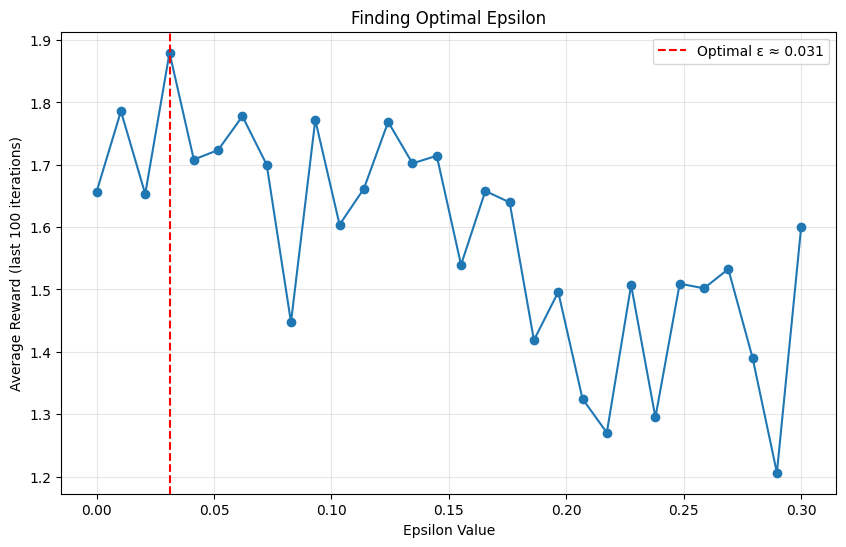

Optimal epsilon: 0.031


In [11]:
epsilon_range = np.linspace(0, 0.3, 30)
final_rewards = []

for eps in epsilon_range:
    rewards = run_epsilon_greedy(eps, 1000)
    # Use average of last 100 iterations as performance metric
    final_rewards.append(np.mean(rewards[-100:]))

plt.figure(figsize=(10, 6))
plt.plot(epsilon_range, final_rewards, marker='o')
plt.xlabel('Epsilon Value')
plt.ylabel('Average Reward (last 100 iterations)')
plt.title('Finding Optimal Epsilon')
plt.grid(True, alpha=0.3)
optimal_epsilon = epsilon_range[np.argmax(final_rewards)]
plt.axvline(x=optimal_epsilon, color='r', linestyle='--', 
            label=f'Optimal ε ≈ {optimal_epsilon:.3f}')
plt.legend()
plt.show()

print(f"Optimal epsilon: {optimal_epsilon:.3f}")

## Optimistic Initial Values

In [12]:
def run_optimistic_greedy(initial_value=10, num_iterations=1000):
    
    num_bandits = len(bandits)
    counts = np.zeros(num_bandits)
    values = np.ones(num_bandits) * initial_value  # Optimistic initialization
    rewards = []
    
    for i in range(num_iterations):
        # Always choose best known bandit (greedy)
        bandit_idx = np.argmax(values)
        
        # Pull lever
        reward = bandits[bandit_idx].pullLever()
        rewards.append(reward)
        
        # Update estimates
        counts[bandit_idx] += 1
        values[bandit_idx] += (reward - values[bandit_idx]) / counts[bandit_idx]
    
    return rewards

Plot the cumulative average of rewards as the number of iterations increases for an optimistic greedy of $Q_1 = 10$ and a non-optimistic $\epsilon = 0.1$ and try to compare which is better.

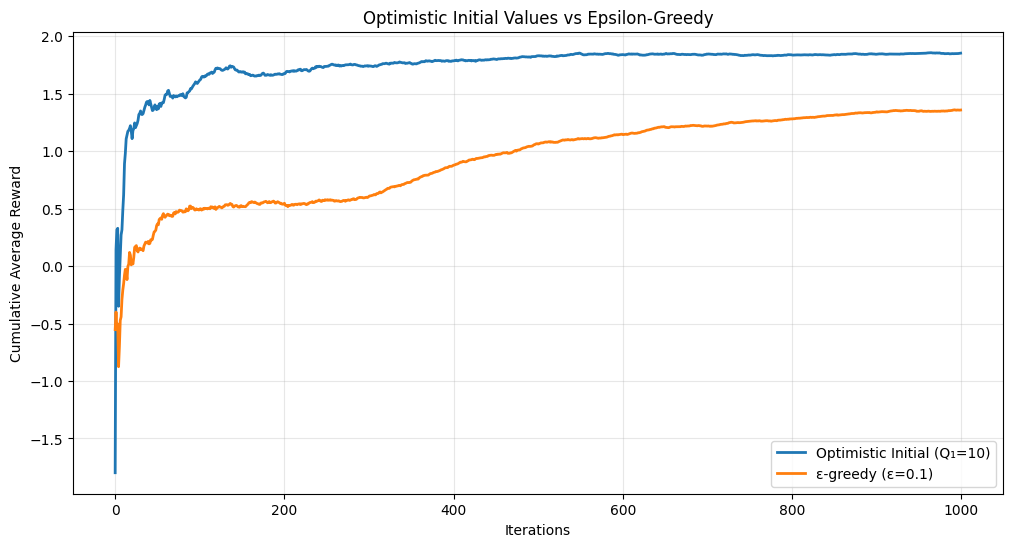

In [13]:
plt.figure(figsize=(12, 6))

optimistic_rewards = run_optimistic_greedy(initial_value=10, num_iterations=1000)
optimistic_avg = np.cumsum(optimistic_rewards) / (np.arange(len(optimistic_rewards)) + 1)
plt.plot(optimistic_avg, label='Optimistic Initial (Q₁=10)', linewidth=2)

epsilon_rewards = run_epsilon_greedy(epsilon=0.1, num_iterations=1000)
epsilon_avg = np.cumsum(epsilon_rewards) / (np.arange(len(epsilon_rewards)) + 1)
plt.plot(epsilon_avg, label='ε-greedy (ε=0.1)', linewidth=2)

plt.xlabel('Iterations')
plt.ylabel('Cumulative Average Reward')
plt.title('Optimistic Initial Values vs Epsilon-Greedy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Upper Confidence Bound (UCB)

In [14]:
def run_ucb(c=2, num_iterations=1000):
    
    num_bandits = len(bandits)
    counts = np.zeros(num_bandits)
    values = np.zeros(num_bandits)
    rewards = []
    
    # Pull each bandit once first
    for i in range(num_bandits):
        reward = bandits[i].pullLever()
        rewards.append(reward)
        counts[i] += 1
        values[i] = reward
    
    # Continue with UCB selection
    for t in range(num_bandits, num_iterations):
        # Calculate UCB for each bandit
        ucb_values = values + c * np.sqrt(np.log(t) / counts)
        
        # Select bandit with highest UCB
        bandit_idx = np.argmax(ucb_values)
        
        # Pull lever
        reward = bandits[bandit_idx].pullLever()
        rewards.append(reward)
        
        # Update estimates
        counts[bandit_idx] += 1
        values[bandit_idx] += (reward - values[bandit_idx]) / counts[bandit_idx]
    
    return rewards

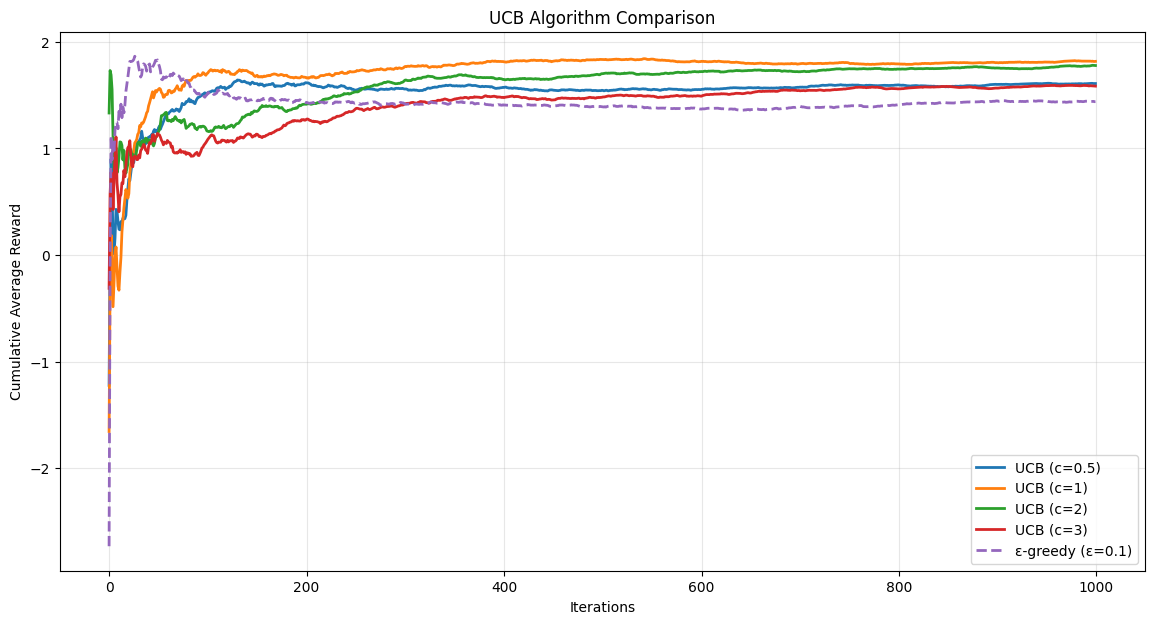

In [15]:
plt.figure(figsize=(14, 7))

# UCB with different c values
for c_val in [0.5, 1, 2, 3]:
    ucb_rewards = run_ucb(c=c_val, num_iterations=1000)
    ucb_avg = np.cumsum(ucb_rewards) / (np.arange(len(ucb_rewards)) + 1)
    plt.plot(ucb_avg, label=f'UCB (c={c_val})', linewidth=2)

# Compare with epsilon-greedy
epsilon_rewards = run_epsilon_greedy(epsilon=0.1, num_iterations=1000)
epsilon_avg = np.cumsum(epsilon_rewards) / (np.arange(len(epsilon_rewards)) + 1)
plt.plot(epsilon_avg, label='ε-greedy (ε=0.1)', linewidth=2, linestyle='--')

plt.xlabel('Iterations')
plt.ylabel('Cumulative Average Reward')
plt.title('UCB Algorithm Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
